### Model Checkpointing and Early Stopping
https://lightning.ai/courses/deep-learning-fundamentals/unit-6-overview-essential-deep-learning-tips-tricks/unit-6.1-model-checkpointing-and-early-stopping/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from common_def import CustomDataModule, CustomDataset

In [2]:
dm = CustomDataModule()
dm.setup(stage='train')

In [3]:
dm.train_dataset.features.dtype
# dm.train_dataset.labels.dtype

dtype('float32')

#### Examine dataset

In [4]:
print(f"""
Train size: {len(dm.train_dataset)}
Val size: {len(dm.val_dataset)}
Test size: {len(dm.test_dataset)}
""")

train_labels_dist = pd.Series(dm.train_dataset.labels).value_counts()
val_labels_dist = pd.Series(dm.val_dataset.labels).value_counts()
test_labels_dist = pd.Series(dm.test_dataset.labels).value_counts()

print(f'Train labels distribution\n{train_labels_dist}')
print(f'\nVal labels distribution\n{val_labels_dist}')
print(f'\nTest labels distribution\n{test_labels_dist}')


Train size: 14400
Val size: 1600
Test size: 4000

Train labels distribution
0    7209
1    7191
dtype: int64

Val labels distribution
1    809
0    791
dtype: int64

Test labels distribution
0    2027
1    1973
dtype: int64


#### Zero-rule baseline

In [5]:
train_baseline_acc = 100 * max(train_labels_dist) / sum(train_labels_dist)
print(f'Train baseline accuracy: {train_baseline_acc:.2f}%')

Train baseline accuracy: 50.06%


#### Model Checkpointing

In [6]:
from lightning.pytorch.callbacks import ModelCheckpoint
from common_def import LightningModel, PyTorchMLP
import lightning
from lightning.pytorch.loggers import CSVLogger

In [7]:
# save the best model with highest val_acc
callbacks = [
    ModelCheckpoint(save_top_k=1, monitor='val_acc', mode='max', save_last=True)
]

In [8]:
torch.manual_seed(12)

torch_model = PyTorchMLP(num_features=100, num_classes=2)
lightning_model = LightningModel(torch_model=torch_model, learning_rate=0.05, num_classes=2)

trainer = lightning.Trainer(
    max_epochs=10, 
    callbacks=callbacks,
    logger=CSVLogger('lightning_logs', name='LightningModel'),
    deterministic=True)

trainer.fit(model=lightning_model, datamodule=dm)

/home/tu/.local/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'torch_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['torch_model'])`.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type               | Params
---------------------------------------------------
0 | torch_model | PyTorchMLP    | 6.5 K 
1 | train_acc   | MulticlassAccuracy | 0     
2 | val_acc     | MulticlassAccuracy | 0     
---------------------------------------------------
6.5 K     Trainable params
0         Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/tu/.local/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/tu/.local/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


#### Visualize metrics

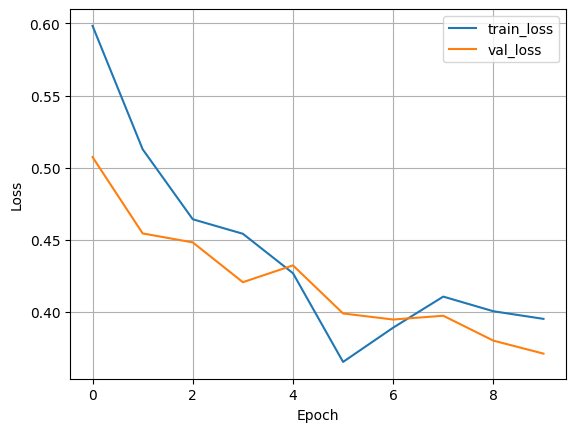

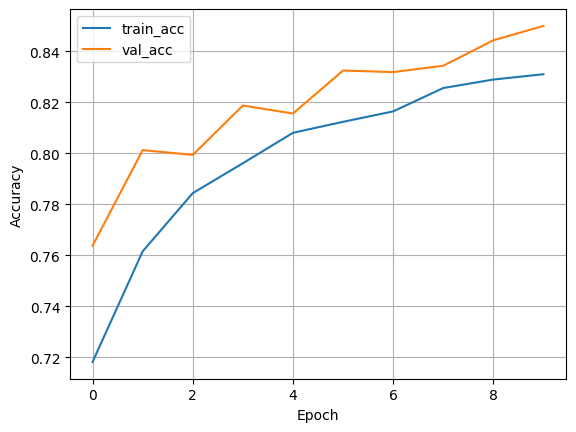

In [14]:
from common_def import plot_csv_logger

plot_csv_logger('lightning_logs/LightningModel/version_5/metrics.csv')

#### Best Checkpoint

In [10]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path='best')

Restoring states from the checkpoint path at lightning_logs/LightningModel/version_5/checkpoints/epoch=9-step=4500.ckpt
Loaded model weights from the checkpoint at lightning_logs/LightningModel/version_5/checkpoints/epoch=9-step=4500.ckpt
/home/tu/.local/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8487499952316284
        test_loss           0.37399837374687195
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.37399837374687195, 'test_acc': 0.8487499952316284}]

In [11]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path='last')

/home/tu/.local/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:186: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8487499952316284
        test_loss           0.37399837374687195
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.37399837374687195, 'test_acc': 0.8487499952316284}]

#### Load the best model checkpoint

In [12]:
trainer.checkpoint_callback.best_model_path
model = PyTorchMLP(num_features=100, num_classes=2)
best_model = LightningModel.load_from_checkpoint(
    checkpoint_path=trainer.checkpoint_callback.best_model_path,
    model=model)

best_model

/home/tu/.local/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'torch_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['torch_model'])`.


LightningModel(
  (torch_model): PyTorchMLP(
    (layers): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=50, out_features=25, bias=True)
      (4): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=25, out_features=2, bias=True)
    )
  )
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
)

In [13]:
trainer.test(model=best_model, datamodule=dm)

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8487499952316284
        test_loss           0.37399837374687195
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.37399837374687195, 'test_acc': 0.8487499952316284}]